# Exploring merge of pluto and sales data

Our goal in this notebook is to merge the pluto and sales data- to do so, we:
1. First, we try merging on just BBL.
2. Then we assess how this merge performed.
3. Given the performance of this merge, we explore other options to merge the two datasets.
    - Merge using the complete set of BBLs for a condo building
    - Merge using the condo billing BBL
4. The final section includes unused code for parsing addresses, which may be useful at a later time.

## 1. Merging on just BBL

First, we naively try merging on just BBL- note we have to construct this feature for the sales data set:

In [1]:
import pandas as pd
import numpy as np

In [2]:
pluto = pd.read_csv('./../pluto/all_pluto.csv')

In [3]:
sales = pd.read_csv('./../sales/all_residential_2011_2015.csv')

In [4]:
bbl_features = ['BOROUGH','BLOCK','LOT']

for feature in bbl_features:
    sales[feature] = sales[feature].astype(str)

In [5]:
def make_bbl(row):
    bbl = row['BOROUGH'] + row['BLOCK'].zfill(5) + row['LOT'].zfill(4)
    return bbl

sales['BBL'] = sales.apply(make_bbl, axis=1).astype(float)

In [6]:
merged = pd.merge(sales, pluto, how='left', on=['BBL'])
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369637 entries, 0 to 369636
Data columns (total 41 columns):
BOROUGH                           369637 non-null object
NEIGHBORHOOD                      369637 non-null object
BUILDING CLASS CATEGORY           369637 non-null object
TAX CLASS AT PRESENT              369637 non-null object
BLOCK                             369637 non-null object
LOT                               369637 non-null object
EASE-MENT                         369637 non-null object
BUILDING CLASS AT PRESENT         369637 non-null object
ADDRESS                           369637 non-null object
APARTMENT NUMBER                  369637 non-null object
ZIP CODE                          369637 non-null int64
RESIDENTIAL UNITS                 369637 non-null int64
COMMERCIAL UNITS                  369637 non-null int64
TOTAL UNITS                       369637 non-null int64
LAND SQUARE FEET                  369637 non-null int64
GROSS SQUARE FEET                 36963

## 2. Assessing naive merge performance.

First, it is apparent that this merge was not particularly successful, given the ~90000 records in the sales data that did not match a BBL in the Pluto dataset. To explain this, we consider the following information about lot numbers from the Pluto data dictionary:

<img src='tax_lot_DD.png' height=600 width=600>

Based on this description of the tax lots in the Pluto dataset, we suspect that the missing values correspond to condos- thus we proceed to check this possible explanation.

In [7]:
merged.loc[merged['Block'].isnull(),'BUILDING CLASS CATEGORY'].value_counts()

13  CONDOS - ELEVATOR APARTMENTS                63609
04  TAX CLASS 1 CONDOS                           6768
15  CONDOS - 2-10 UNIT RESIDENTIAL               5673
17  CONDO COOPS                                  4240
12  CONDOS - WALKUP APARTMENTS                   4153
17  CONDOPS                                      2368
16  CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT       453
05  TAX CLASS 1 VACANT LAND                       317
08  RENTALS - ELEVATOR APARTMENTS                 143
07  RENTALS - WALKUP APARTMENTS                   121
11A CONDO-RENTALS                                 113
02  TWO FAMILY HOMES                              109
01  ONE FAMILY HOMES                               72
02  TWO FAMILY DWELLINGS                           65
03  THREE FAMILY HOMES                             52
03  THREE FAMILY DWELLINGS                         38
01  ONE FAMILY DWELLINGS                           36
06  TAX CLASS 1 - OTHER                            33
14  RENTALS - 4-10 UNIT     

Thus, it is apparent the vast majority of these mismatched BBL's correspond to condos. We can confirm this another way, since the lot number is informative of the lot type (again from Pluto Data Dictionary):
<img src='meaning_of_lot_no.png' height=400 width=400>
We thus present a histogram of the lot numbers for mismatched sale records:

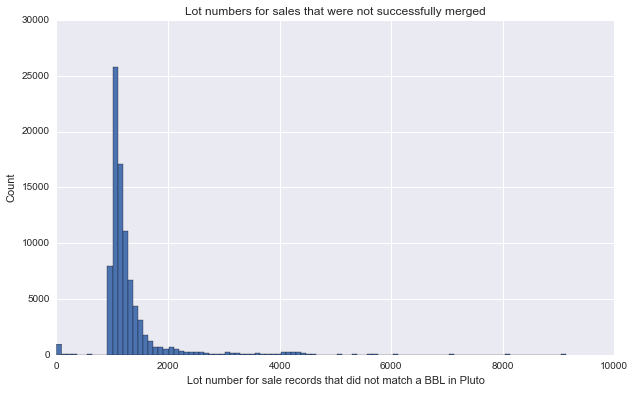

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(10,6))
plt.hist(merged.loc[merged['Borough'].isnull(),'LOT'].astype(int).values, bins=100)
plt.ylabel('Count')
plt.xlabel('Lot number for sale records that did not match a BBL in Pluto')
plt.title('Lot numbers for sales that were not successfully merged')
plt.show()

## 3. Attempting to correct the mismatch for condos

Thus, we now must try to correct this mismatch for condos. We will take a two-step approach, recalling there are two ways condo BBLs are represented in the PLUTO dataset:

1. Using the lowest BBL number in the range of BBLs included in the condo;
2. Using the Condominium Billing BBL.

We will try to correct for these BBL representations as follows:

1. First, we will  will be to use the CondoNo/BBL map available from https://github.com/chriswhong/nyc-tax-data-notes/blob/master/condolookup.csv. Using this dataset, we can find all the BBLs corresponding to a condo number, and then use these complete set of BBLs to merge with PLUTO where (in pluto) the BBL is represented using the lowest BBL.
2. Second, we will use the map from BBLs to condo billing BBLs available at https://raw.githubusercontent.com/chriswhong/taxMap/master/scripts/NYCCondoPad.csv. This will allow us to merge the sales data with PLUTO where the PLUTO BBL is recorded using the condo billing BBL.

### Approach 1: Merging over the set of BBLs for a condo building

In [41]:
condos = pd.read_csv('condolookup.csv', index_col=None)
condos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239819 entries, 0 to 239818
Data columns (total 2 columns):
condono    239819 non-null int64
bbl        239819 non-null int64
dtypes: int64(2)
memory usage: 3.7 MB


In [45]:
condos.head(100)

,condono,bbl
0,2288,1001871001
1,2288,1001871002
2,2288,1001871003
3,256,1002461001
4,256,1002461002
5,256,1002461003
6,256,1002461004
7,256,1002461005
8,256,1002461006
9,256,1002461007


Based on this view of the data, we can see that the bbls are sorted in increasing order within each condo number. Unfortunately, the condo numbers are not unique:

In [46]:
condos[condos['condono']==100]

,condono,bbl
20916,100,5028291053
20917,100,5028291054
20918,100,5028291055
20919,100,5028291056
20920,100,5028291057
20921,100,5028291058
20922,100,5028291059
20923,100,5028291060
114867,100,1015051040
114868,100,1015051041


As we can see, the condono 100 is maps to BBLs that span different boroughs (as indicated by the most significant digit in the BBL). Thus our approach will be to parse the csv file as follows:
1. Assign new CondoIDs to each adjacent block of records with the same condo number.

In [92]:
condo_id_groups = []
CondoID = 1
with file('condolookup.csv','r') as f:
    header = f.readline().strip().replace('"',"").split(',')
    last_condono, bbl = f.readline().strip().split(',')
    last_condono = int(last_condono)
    bbl = int(bbl)
    condo_id_groups.append((CondoID, bbl))
    for l in f:
        condono, bbl = l.strip().split(',')
        condono = int(condono)
        bbl = int(bbl)
        if condono == last_condono:
            condo_id_groups.append((CondoID, bbl))
        else:
            CondoID += 1
            condo_id_groups.append((CondoID, bbl))
            last_condono = condono

In [93]:
len(condo_id_groups)

239819

In [94]:
new_condos = pd.DataFrame.from_records(condo_id_groups)

In [95]:
new_condos.columns = ['CondoID','BBL']
new_condos.head()

,CondoID,BBL
0,1,1001871001
1,1,1001871002
2,1,1001871003
3,2,1002461001
4,2,1002461002


In [96]:
unmatched = merged.loc[merged['Block'].isnull(), ['BBL']]
unmatched.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88489 entries, 1 to 369621
Data columns (total 1 columns):
BBL    88489 non-null float64
dtypes: float64(1)
memory usage: 1.4 MB


In [97]:
merge_unmatched = pd.merge(unmatched, new_condos, how='left', on=['BBL'])
merge_unmatched.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88492 entries, 0 to 88491
Data columns (total 2 columns):
BBL        88492 non-null float64
CondoID    85251 non-null float64
dtypes: float64(2)
memory usage: 2.0 MB


In [98]:
merge_unmatched = pd.merge(merge_unmatched, new_condos, how='left', on='CondoID')
merge_unmatched.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20200013 entries, 0 to 20200012
Data columns (total 3 columns):
BBL_x      float64
CondoID    float64
BBL_y      float64
dtypes: float64(3)
memory usage: 616.5 MB


In [100]:
w_pluto = pd.merge(merge_unmatched, pluto[['BBL']], how='right', left_on=['BBL_y'], right_on=['BBL'])

In [101]:
w_pluto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 892743 entries, 0 to 892742
Data columns (total 4 columns):
BBL_x      34818 non-null float64
CondoID    34818 non-null float64
BBL_y      34818 non-null float64
BBL        892743 non-null int64
dtypes: float64(3), int64(1)
memory usage: 34.1 MB


In [107]:
w_pluto.head()

,BBL_x,CondoID,BBL_y,BBL
0,4.009491e+09,11438.0,4.009478e+09,4009477501
1,4.009471e+09,11438.0,4.009478e+09,4009477501
2,4.009471e+09,11438.0,4.009478e+09,4009477501
3,4.009471e+09,11438.0,4.009478e+09,4009477501
4,4.009471e+09,11438.0,4.009478e+09,4009477501


In [108]:
w_pluto.drop_duplicates(inplace=True)
w_pluto.dropna(subset=['BBL_x'], inplace=True)
w_pluto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27595 entries, 0 to 34817
Data columns (total 4 columns):
BBL_x      27595 non-null float64
CondoID    27595 non-null float64
BBL_y      27595 non-null float64
BBL        27595 non-null int64
dtypes: float64(3), int64(1)
memory usage: 1.1 MB


In [109]:
for feat in w_pluto.columns:
    w_pluto[feat] = w_pluto[feat].astype(int)
w_pluto.head()

,BBL_x,CondoID,BBL_y,BBL
0,4009491018,11438,4009477501,4009477501
1,4009471014,11438,4009477501,4009477501
2,4009471037,11438,4009477501,4009477501
3,4009471112,11438,4009477501,4009477501
4,4009471115,11438,4009477501,4009477501


In [112]:
w_pluto.drop(['CondoID', 'BBL_y'], axis=1, inplace=True)
w_pluto.head()

,BBL_x,BBL
0,4009491018,4009477501
1,4009471014,4009477501
2,4009471037,4009477501
3,4009471112,4009477501
4,4009471115,4009477501


Now that we have a mapping from the sale BBLs to the representative BBL for the condo, we'll retry merging by BBL

In [113]:
sales['mapped_BBL'] = sales['BBL']
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369637 entries, 0 to 369636
Data columns (total 23 columns):
BOROUGH                           369637 non-null object
NEIGHBORHOOD                      369637 non-null object
BUILDING CLASS CATEGORY           369637 non-null object
TAX CLASS AT PRESENT              369637 non-null object
BLOCK                             369637 non-null object
LOT                               369637 non-null object
EASE-MENT                         369637 non-null object
BUILDING CLASS AT PRESENT         369637 non-null object
ADDRESS                           369637 non-null object
APARTMENT NUMBER                  369637 non-null object
ZIP CODE                          369637 non-null int64
RESIDENTIAL UNITS                 369637 non-null int64
COMMERCIAL UNITS                  369637 non-null int64
TOTAL UNITS                       369637 non-null int64
LAND SQUARE FEET                  369637 non-null int64
GROSS SQUARE FEET                 36963

In [117]:
sales['mapped_BBL'] = sales['mapped_BBL'].replace(w_pluto['BBL_x'].values, w_pluto['BBL'].values)

In [119]:
new_merged = pd.merge(sales, pluto, how='left', left_on=['mapped_BBL'], right_on=['BBL'])
new_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369637 entries, 0 to 369636
Data columns (total 43 columns):
BOROUGH                           369637 non-null object
NEIGHBORHOOD                      369637 non-null object
BUILDING CLASS CATEGORY           369637 non-null object
TAX CLASS AT PRESENT              369637 non-null object
BLOCK                             369637 non-null object
LOT                               369637 non-null object
EASE-MENT                         369637 non-null object
BUILDING CLASS AT PRESENT         369637 non-null object
ADDRESS                           369637 non-null object
APARTMENT NUMBER                  369637 non-null object
ZIP CODE                          369637 non-null int64
RESIDENTIAL UNITS                 369637 non-null int64
COMMERCIAL UNITS                  369637 non-null int64
TOTAL UNITS                       369637 non-null int64
LAND SQUARE FEET                  369637 non-null int64
GROSS SQUARE FEET                 36963

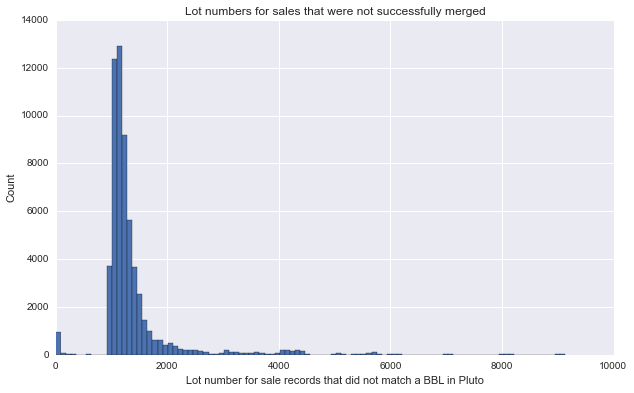

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(10,6))
plt.hist(new_merged.loc[new_merged['Borough'].isnull(),'LOT'].astype(int).values, bins=100)
plt.ylabel('Count')
plt.xlabel('Lot number for sale records that did not match a BBL in Pluto')
plt.title('Lot numbers for sales that were not successfully merged')
plt.show()

### Approach 2: Merging using the Billing BBL

In [163]:
condoPAD = pd.read_csv('NYCCondoPad.csv', index_col=None, usecols=['loboro','loblock','lolot','hiboro','hiblock','hilot','billboro','billblock','billlot'])
condoPAD.replace(r"\s+", np.nan, regex=True, inplace=True)
condoPAD.dropna(axis=0, inplace=True)
condoPAD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25854 entries, 0 to 29271
Data columns (total 9 columns):
loboro       25854 non-null int64
loblock      25854 non-null int64
lolot        25854 non-null int64
hiboro       25854 non-null int64
hiblock      25854 non-null int64
hilot        25854 non-null int64
billboro     25854 non-null object
billblock    25854 non-null object
billlot      25854 non-null object
dtypes: int64(6), object(3)
memory usage: 2.0+ MB


In [164]:
def make_bbl_ranges(row):
    pairs = []
    lbbl = int(str(row['loboro'])+str(row['loblock']).zfill(5)+str(row['lolot']).zfill(4))
    hbbl = int(str(row['hiboro'])+str(row['hiblock']).zfill(5)+str(row['hilot']).zfill(4))
    billbbl = int(str(row['billboro'])+str(row['billblock']).zfill(5)+str(row['billlot']).zfill(4))
    for bbl in range(lbbl, hbbl+1):
        pairs.append((bbl, billbbl))
    return pairs

make_bbl_ranges(condoPAD.loc[3])

[(1000071001, 1000077501), (1000071002, 1000077501)]

In [165]:
all_pairs = []
for i, row in condoPAD.iterrows():
    all_pairs.extend(make_bbl_ranges(row))

In [169]:
bbl_to_billing = pd.DataFrame.from_records(all_pairs)
bbl_to_billing.columns = ['BBL','BillingBBL']

In [170]:
unmatched.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88489 entries, 1 to 369621
Data columns (total 1 columns):
BBL    88489 non-null float64
dtypes: float64(1)
memory usage: 1.4 MB


In [171]:
merge_unmatched_billing = pd.merge(unmatched, bbl_to_billing, how='left', on=['BBL'])
merge_unmatched_billing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88489 entries, 0 to 88488
Data columns (total 2 columns):
BBL           88489 non-null float64
BillingBBL    78886 non-null float64
dtypes: float64(2)
memory usage: 2.0 MB


In [172]:
w_pluto_billing = pd.merge(merge_unmatched_billing, pluto[['BBL']], how='left', left_on=['BillingBBL'], right_on=['BBL'])
w_pluto_billing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88489 entries, 0 to 88488
Data columns (total 3 columns):
BBL_x         88489 non-null float64
BillingBBL    78886 non-null float64
BBL_y         78798 non-null float64
dtypes: float64(3)
memory usage: 2.7 MB


In [174]:
w_pluto_billing.drop('BillingBBL', axis=1, inplace=True)
w_pluto_billing.head()

,BBL_x,BBL_y
0,4.009491e+09,4.009498e+09
1,4.159041e+09,4.159048e+09
2,4.159041e+09,4.159048e+09
3,4.159311e+09,4.159318e+09
4,4.159311e+09,4.159318e+09


Note this approach seems particularly promising. Now we put it all together- our approach will be to:
1. First left merge naively (sales and pluto on BBL)
2. Fill missing BBLs (not found in pluto) with the BBL found in pluto for that same condo (i.e. lowest BBL in the building, not the billing BBL).
3. Fill remaining missing BBLs with the BBL found in pluto matching the condo billing BBL.

In [182]:
sales = pd.read_csv('./../sales/all_residential_2011_2015.csv')

In [183]:
pluto = pd.read_csv('./../pluto/all_pluto.csv', usecols=['BBL','Lot'])

In [184]:
bbl_features = ['BOROUGH','BLOCK','LOT']

for feature in bbl_features:
    sales[feature] = sales[feature].astype(str)

In [185]:
def make_bbl(row):
    bbl = row['BOROUGH'] + row['BLOCK'].zfill(5) + row['LOT'].zfill(4)
    return bbl

sales['BBL'] = sales.apply(make_bbl, axis=1).astype(float)

In [186]:
sales['mapped_BBL'] = sales['BBL']
sales['mapped_BBL'] = sales['mapped_BBL'].replace(w_pluto['BBL_x'].values, w_pluto['BBL'].values)
sales['mapped_BBL'] = sales['mapped_BBL'].replace(w_pluto_billing['BBL_x'].values, w_pluto_billing['BBL_y'].values)

In [188]:
merged = pd.merge(sales, pluto, how='left', left_on=['mapped_BBL'], right_on=['BBL'])
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369637 entries, 0 to 369636
Data columns (total 25 columns):
BOROUGH                           369637 non-null object
NEIGHBORHOOD                      369637 non-null object
BUILDING CLASS CATEGORY           369637 non-null object
TAX CLASS AT PRESENT              369637 non-null object
BLOCK                             369637 non-null object
LOT                               369637 non-null object
EASE-MENT                         369637 non-null object
BUILDING CLASS AT PRESENT         369637 non-null object
ADDRESS                           369637 non-null object
APARTMENT NUMBER                  369637 non-null object
ZIP CODE                          369637 non-null int64
RESIDENTIAL UNITS                 369637 non-null int64
COMMERCIAL UNITS                  369637 non-null int64
TOTAL UNITS                       369637 non-null int64
LAND SQUARE FEET                  369637 non-null int64
GROSS SQUARE FEET                 36963

As a sanity check, let's flip the order of replacement and make sure it returns the same dataframe.

In [191]:
sales['mapped_BBL'] = sales['BBL']
sales['mapped_BBL'] = sales['mapped_BBL'].replace(w_pluto_billing['BBL_x'].values, w_pluto_billing['BBL_y'].values)
sales['mapped_BBL'] = sales['mapped_BBL'].replace(w_pluto['BBL_x'].values, w_pluto['BBL'].values)

In [192]:
mergedflipped = pd.merge(sales, pluto, how='left', left_on=['mapped_BBL'], right_on=['BBL'])
mergedflipped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369637 entries, 0 to 369636
Data columns (total 25 columns):
BOROUGH                           369637 non-null object
NEIGHBORHOOD                      369637 non-null object
BUILDING CLASS CATEGORY           369637 non-null object
TAX CLASS AT PRESENT              369637 non-null object
BLOCK                             369637 non-null object
LOT                               369637 non-null object
EASE-MENT                         369637 non-null object
BUILDING CLASS AT PRESENT         369637 non-null object
ADDRESS                           369637 non-null object
APARTMENT NUMBER                  369637 non-null object
ZIP CODE                          369637 non-null int64
RESIDENTIAL UNITS                 369637 non-null int64
COMMERCIAL UNITS                  369637 non-null int64
TOTAL UNITS                       369637 non-null int64
LAND SQUARE FEET                  369637 non-null int64
GROSS SQUARE FEET                 36963

## 4. Unused code (for potential approach involving merging by address)

In [140]:
def address_to_list(address):
    return filter(None, str(address).strip().split(' '))

In [141]:
def is_int(s):
    try:
        int(s)
        return True
    except ValueError:
        return False

In [142]:
def street_num_and_name(address):
    address_list = address_to_list(address)
    if len(address_list)==0:
        return np.nan
    else: #Some info in address field
        if is_int(address_list[0].split('-')[0]): #note need to split on '-' for queens addresses
            street_name = ' '.join(address_list[1:])
            street_name_list = street_name.split(',')
            if len(street_name_list) == 1:
                unit_nums = np.nan
            elif len(street_name_list) >= 2:
                street_name = street_name_list[0]
                unit_nums = street_name_list[1:]
            else:
                print address
                raise ValueError
            return address_list[0], street_name, unit_nums
        else:
            return np.nan, ' '.join(address_list), np.nan

In [144]:
def split_df_address(df, colname):
    features = ['Street number','Street name', 'Unit number']
    if colname.isupper():
        features = [x.upper() for x in features]
    df[colname] = df[colname].apply(street_num_and_name)
    df[features] = df[colname].apply(pd.Series)